In [1]:
import numpy as np
from beryllium import plotting, stats
import os
import matplotlib.pyplot as plt

from simtk import unit
from openmmtools.constants import kB
temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [14]:
all_sims = []

for results_file in os.listdir('results/'):
    try:
        results = np.load(f'results/{results_file}',allow_pickle=True)
        all_sims.append(results)
    except IsADirectoryError:
        continue

In [15]:
import networkx as nx
mm_g = nx.DiGraph()

experimental = [-9.540000 , -10.940000 , -8.980000 , -11.310000 , -9.210000 , -8.260000 , -10.980000 , -7.750000 , -    9.560000 , -7.420000 , -11.280000 , -9 , -9.700000 , -11.700000 , -9.780000 , -10.530000]

for sim in all_sims:
    ligA = int(sim.directory[3:].split('to')[0])
    ligB = int(sim.directory[3:].split('to')[1])
    mm_g.add_edge(ligA, ligB,calc_DDG=-sim.bindingdg/sim.bindingdg.unit, calc_dDDG=sim.bindingddg/sim.bindingddg.unit,exp_DDG=(experimental[ligB] - experimental[ligA]),exp_dDDG=0.1)    
    

In [16]:
mm_g_4fs = nx.DiGraph()

sims_4fs = []

for results_file in os.listdir('results/4fs_with_restraints/'):
    results = np.load(f'results/4fs_with_restraints/{results_file}',allow_pickle=True)
    sims_4fs.append(results)

for sim in sims_4fs:
    ligA = int(sim.directory[3:].split('to')[0])
    ligB = int(sim.directory[3:].split('to')[1])
    mm_g_4fs.add_edge(ligA, ligB,calc_DDG=-sim.bindingdg/sim.bindingdg.unit, calc_dDDG=sim.bindingddg/sim.bindingddg.unit,exp_DDG=(experimental[ligB] - experimental[ligA]),exp_dDDG=0.1)    
    

In [17]:
mm_g_no_endstate = nx.DiGraph()
endstate_corrections = []

for sim in all_sims:
    ligA = int(sim.directory[3:].split('to')[0])
    ligB = int(sim.directory[3:].split('to')[1])
    no_e = ((sim._solf_ij[1,-2]-sim._comf_ij[1,-2])*kT).in_units_of(unit.kilocalories_per_mole)
    no_e_corr = ((((sim._soldf_ij[1,-2])**2+sim._comdf_ij[1,-2]**2)**0.5)*kT).in_units_of(unit.kilocalories_per_mole)
    endstate_corrections.append(np.abs(no_e - sim.bindingdg))
#     print(no_e_corr)
    mm_g_no_endstate.add_edge(ligA, ligB,calc_DDG=-no_e/sim.bindingddg.unit, calc_dDDG=no_e_corr/sim.bindingddg.unit,exp_DDG=(experimental[ligB] - experimental[ligA]),exp_dDDG=0.1)    
#     endstate_correction = sim.bindingdg/sim.bindingdg.unit - (sim._comdf_ij[1:-1]-sim._soldf_ij[1:-1])

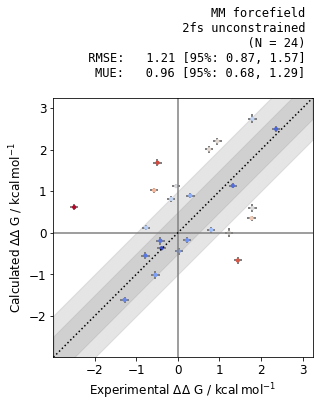

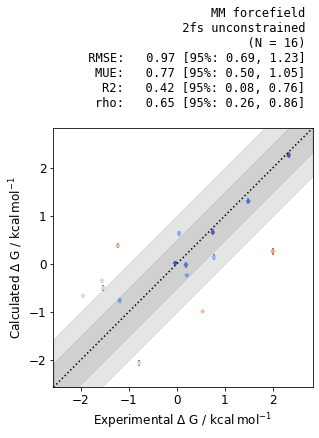

In [18]:
plotting.plot_DDGs(mm_g,title='MM forcefield \n 2fs unconstrained')

f_i_calc, C_calc = stats.mle(mm_g, factor='calc_DDG')
variance = np.diagonal(C_calc)
for i, (f_i, df_i) in enumerate(zip(f_i_calc, variance**0.5)):
    mm_g.nodes[i]['calc_DG'] = f_i
    mm_g.nodes[i]['calc_dDG'] = df_i
    mm_g.nodes[i]['exp_DG'] = experimental[i]
    mm_g.nodes[i]['exp_dDG'] = 0.01
    
plotting.plot_DGs(mm_g,title='MM forcefield \n 2fs unconstrained')

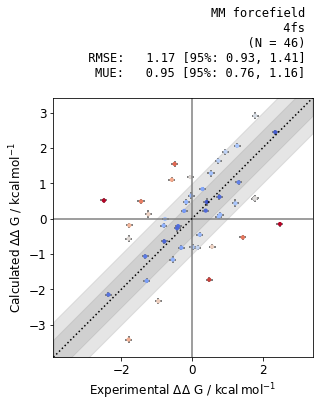

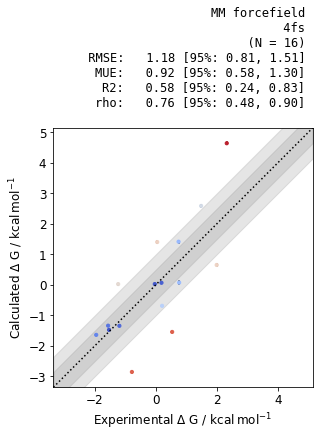

In [90]:
plotting.plot_DDGs(mm_g_4fs,title='MM forcefield \n 4fs')

f_i_calc, C_calc = stats.mle(mm_g_4fs, factor='calc_DDG')
variance = np.diagonal(C_calc)
for i, (f_i, df_i) in enumerate(zip(f_i_calc, variance**0.5)):
    mm_g_4fs.nodes[i]['calc_DG'] = f_i
    mm_g_4fs.nodes[i]['calc_dDG'] = df_i
    mm_g_4fs.nodes[i]['exp_DG'] = experimental[i]
    mm_g_4fs.nodes[i]['exp_dDG'] = 0.01
    
plotting.plot_DGs(mm_g_4fs,title='MM forcefield \n 4fs')

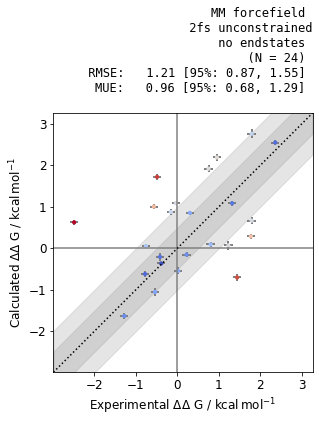

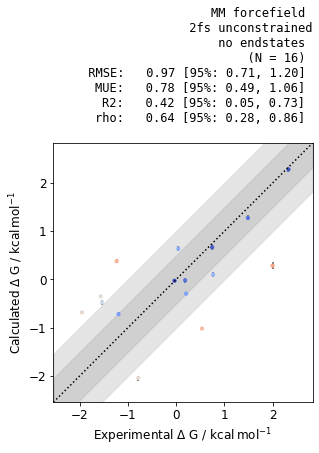

In [22]:
plotting.plot_DDGs(mm_g_no_endstate,title='MM forcefield \n 2fs unconstrained\n no endstates')

f_i_calc, C_calc = stats.mle(mm_g_no_endstate, factor='calc_DDG')
variance = np.diagonal(C_calc)
for i, (f_i, df_i) in enumerate(zip(f_i_calc, variance**0.5)):
    mm_g_no_endstate.nodes[i]['calc_DG'] = f_i
    mm_g_no_endstate.nodes[i]['calc_dDG'] = df_i
    mm_g_no_endstate.nodes[i]['exp_DG'] = experimental[i]
    mm_g_no_endstate.nodes[i]['exp_dDG'] = 0.01
    
plotting.plot_DGs(mm_g_no_endstate,title='MM forcefield \n 2fs unconstrained\n no endstates')

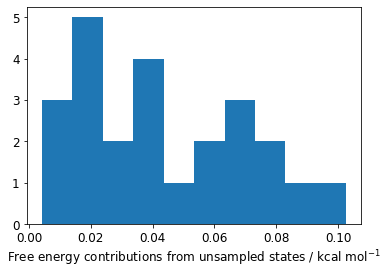

In [23]:
plt.hist(endstate_corrections)
plt.xlabel('Free energy contributions from unsampled states / kcal mol'+r'$^{-1}$')
plt.show()

In [25]:
# calc = []
# exp = []

# for edge in mm_g.edges(data=True):
#     calc.append(edge[2]['calc_DDG'])
#     exp.append(edge[2]['exp_DDG'])
    
# print(calc)
# print(exp)

In [26]:
### change this to load from disc somewhere

ani_corr = {0:( 2.986588908718666, 0.03663977646315734),
1:( 1.3186733177485874, 0.0776026699685437),
2:( 2.1753637128968255, 0.0816007866875901),
3:( 0.8648053638513665, 0.0660595761713285),
4:( 2.436850875774864, 0.04503815267650755),
5:( 2.0195452331311534, 0.0623961413678191),
6:( 0.35446810155850833, 0.063469216200727),
7:( 2.4697403370032553, 0.0548558116709272),
8:( 1.5036620116024277, 0.0601217980301196),
9:( 1.9944748595186974, 0.0501334655488721),
10:( 0.4732923875744454, 0.0779098126838084),
11:( 1.7836961786567698, 0.0709795492529514),
12:( 1.3734898740977515, 0.0681958387838080),
13:( 0.6080148447831161, 0.0516803228645014),
14:( 1.6981176220076157, 0.0356215918101562),
15:( 3.8008517268861177, 0.0731102090243027)   
}

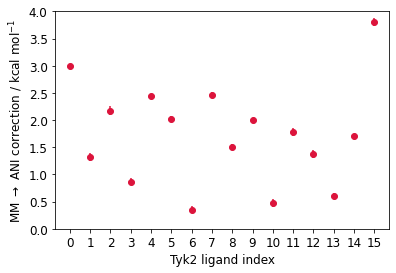

In [86]:
plt.scatter(list(ani_corr.keys()),[x[0] for x in ani_corr.values()],color='crimson')
plt.errorbar(list(ani_corr.keys()),[x[0] for x in ani_corr.values()],yerr=[x[1] for x in ani_corr.values()],linestyle='none',color='crimson')
plt.xlabel('Tyk2 ligand index')
plt.ylabel(r'MM $\rightarrow$ ANI correction / kcal mol'+r'$^{-1}$')
# print(np.max([x[0] for x in ani_corr.values()]))
plt.ylim(0., np.ceil(np.max([x[0] for x in ani_corr.values()])))
plt.xticks(list(ani_corr.keys()),labels=list(ani_corr.keys()))
plt.show()

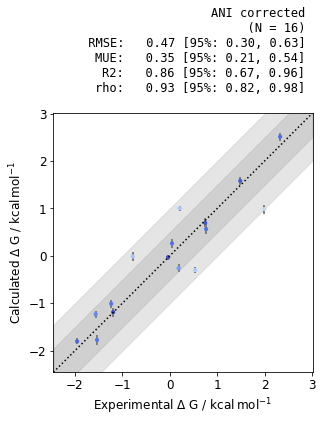

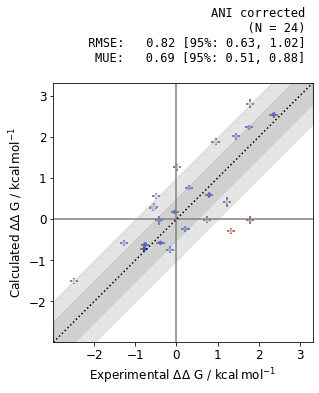

In [87]:
import copy

ani_g = copy.deepcopy(mm_g)

for node in ani_g.nodes(data=True):
    node[1]['calc_DG'] =  node[1]['calc_DG'] + ani_corr[node[0]][0]
    node[1]['calc_dDG'] =  (node[1]['calc_dDG']**2 + ani_corr[node[0]][1]**2)**0.5 
plotting.plot_DGs(ani_g,title='ANI corrected')

for edge in ani_g.edges(data=True):
    edge[2]['calc_DDG'] = ani_g.nodes[edge[1]]['calc_DG'] - ani_g.nodes[edge[0]]['calc_DG']
plotting.plot_DDGs(ani_g,title='ANI corrected')

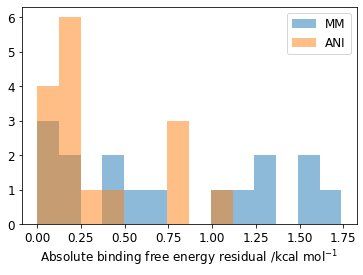

In [88]:
mm_residuals = []

calc_shift = np.mean([node[1]['calc_DG'] for node in mm_g.nodes(data=True)])
exp_shift = np.mean([node[1]['exp_DG'] for node in mm_g.nodes(data=True)])

for node in mm_g.nodes(data=True):
    mm_residuals.append(np.abs(node[1]['calc_DG']-calc_shift - node[1]['exp_DG']+exp_shift))

ani_residuals = []
calc_shift = np.mean([node[1]['calc_DG'] for node in ani_g.nodes(data=True)])
exp_shift = np.mean([node[1]['exp_DG'] for node in ani_g.nodes(data=True)])

for node in ani_g.nodes(data=True):
    ani_residuals.append(np.abs(node[1]['calc_DG']-calc_shift - node[1]['exp_DG']+exp_shift))
    
max = np.max(mm_residuals + ani_residuals)

bins = np.linspace(0,max,15)
plt.hist(mm_residuals,bins=bins,label='MM',alpha=0.5)
plt.hist(ani_residuals,bins=bins,label='ANI',alpha=0.5)
plt.legend()
plt.xlabel('Absolute binding free energy residual /' + r'kcal mol$^{-1}$')
plt.show()

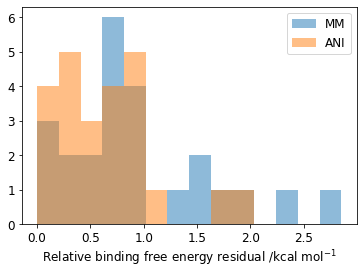

In [89]:
mm_residuals = []

calc_shift = np.mean([e[2]['calc_DDG'] for e in mm_g.edges(data=True)])
exp_shift = np.mean([e[2]['exp_DDG'] for e in mm_g.edges(data=True)])

for e in mm_g.edges(data=True):
    mm_residuals.append(np.abs(e[2]['calc_DDG']-calc_shift - e[2]['exp_DDG']+exp_shift))

ani_residuals = []
calc_shift = np.mean([e[2]['calc_DDG'] for e in ani_g.edges(data=True)])
exp_shift = np.mean([e[2]['exp_DDG'] for e in ani_g.edges(data=True)])

for e in ani_g.edges(data=True):
    ani_residuals.append(np.abs(e[2]['calc_DDG']-calc_shift - e[2]['exp_DDG']+exp_shift))
    
max = np.max(mm_residuals + ani_residuals)

bins = np.linspace(0,max,15)
plt.hist(mm_residuals,bins=bins,label='MM',alpha=0.5)
plt.hist(ani_residuals,bins=bins,label='ANI',alpha=0.5)
plt.legend()
plt.xlabel('Relative binding free energy residual /' + r'kcal mol$^{-1}$')
plt.show()